<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/Navec_CNN-len64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
!pip install pymorphy2 --quiet
!pip install navec --quiet
!pip install wget --quiet

In [126]:
import wget
import os
import sys
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymorphy2
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from navec import Navec

# **Get cleaned dataset**

In [127]:
PATH_CLEANED_DATASET = 'data_cleaned_RU.csv'
url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/'+PATH_CLEANED_DATASET

if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

**Parse**

In [128]:
df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
df.sample(10)

,comment,toxic
8581,взаиморасчёт между страна происходить почти ис...,0
13294,первый что приходить голова но такой программ...,0
773,что смешной весь сам серб давно категорически ...,1
8745,конечно есть нюанс который не хотеться бы разг...,0
746,ну вы такой мусорк я просто интересно откуда в...,0
4234,где брать раскрой тоже хотеть бы как нибыть по...,0
11422,напылять пенополиуретан чем маленький плотност...,1
391,сука что ты голова,1
8323,на это есть правило работа документ если сотру...,0
167,у ты что интоксикация украинский мир,1


In [129]:
print("max :",df.comment.str.len().max())
print("min :",df.comment.str.len().min())
print("mean :",df.comment.str.len().mean())

max : 6728
min : 1
mean : 159.97800444074383


max:  890
min:  0
mean:  24.667291146267


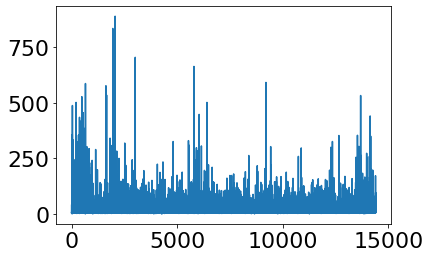

In [130]:
import statistics

print("max: ",max(list(map(lambda comment: len(comment.split()),df.comment))))
print("min: ",min(list(map(lambda comment: len(comment.split()),df.comment))))
print("mean: ",statistics.mean(list(map(lambda comment: len(comment.split()),df.comment))))
plt.plot(df.comment.index,list(map(lambda comment: len(comment.split()),df.comment)))

In [131]:
sentences = df.comment.values
labels = df.toxic.values

**Split**

In [132]:
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.2, random_state=42)   # .15  .2
print(X_train.shape)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=42) # .1764705882352941   .25

(11529,)


In [133]:
X_train.shape

(8646,)

In [134]:
y_train.shape

(8646,)

In [135]:
X_test.shape

(2883,)

In [136]:
y_test.shape

(2883,)

In [137]:
X_val.shape

(2883,)

In [138]:
y_val.shape

(2883,)

In [139]:
X_train.shape

(8646,)

In [140]:
y_train.shape

(8646,)

In [141]:
from navec import Navec

url = 'https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar'
PATH_NAVEC = 'navec_hudlit_v1_12B_500K_300d_100q.tar'

if not os.path.exists(PATH_NAVEC):
    wget.download(url)
navec = Navec.load(PATH_NAVEC)

In [142]:
NAVEC_UNK= '<unk>'
NAVEC_PAD= '<pad>'
DIMENSION_EMBEDDING=navec.get('<unk>').shape[0]

In [143]:
def vectorize_sentence(sentence: str, vectorizer=navec,unc_token =NAVEC_UNK, pad_token = NAVEC_PAD, max_sequence_length=64) -> np.array:
    tokens = sentence.split()
    embedd_tokens = [navec.get(t, navec[unc_token]) for t in tokens[:max_sequence_length]]
    if len(embedd_tokens) < max_sequence_length:
        embedd_tokens += [navec[pad_token]] * (max_sequence_length - len(embedd_tokens))
    return np.array(embedd_tokens)

In [144]:
# получить длину(количество слов) отзывов в 75% датасета
sequence_length=int(round(np.percentile(list(map(lambda sentence: len(sentence.split()), X_train)), 75)))
sequence_length

28

In [145]:
sequence_length=64

In [146]:
navec.get('<unk>').shape[0]

300

In [147]:
X_train = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=navec,
        unc_token =NAVEC_UNK,
        pad_token = NAVEC_PAD,
        max_sequence_length=sequence_length),
    X_train.flatten()
    )
))

X_val = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=navec,
        unc_token =NAVEC_UNK,
        pad_token = NAVEC_PAD,
        max_sequence_length=sequence_length),
    X_val.flatten()
    )
))

X_test = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=navec,
        unc_token =NAVEC_UNK,
        pad_token = NAVEC_PAD,
        max_sequence_length=sequence_length),
    X_test.flatten()
    )
))


In [148]:
X_train.shape

(8646, 64, 300)

**Build RNN model**

Model: "Glove-Navec_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 62, 256)           230656    
                                                                 
 gru_4 (GRU)                 (None, 128)               148224    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 387,201
Trainable params: 387,201
Non

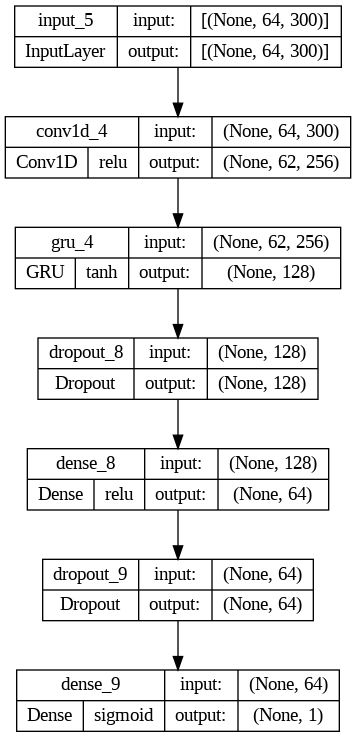

In [149]:
import tensorflow as tf
from tensorflow.keras.metrics import TruePositives,FalsePositives,TrueNegatives,FalseNegatives,BinaryAccuracy,Precision,Recall,AUC,AUC
from tensorflow.keras import Sequential,losses
from tensorflow.keras.layers import Input, Dense, Dropout,Conv1D,GlobalMaxPool1D,SpatialDropout1D,GRU
from tensorflow.keras.utils import plot_model

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      AUC(name='prc', curve='PR'), # precision-recall curve
]

SEED = 42
# SPLIT = 0.2
EPOCHS = 50
BATCH_SIZE = 512
MODEL_NAME = 'Glove-Navec_CNN'

negative_count, neutral_count = np.bincount(y_train)

initial_output_bias = tf.keras.initializers.Constant(
    np.log([neutral_count/negative_count])
)

model = tf.keras.Sequential(
    [
    Input(shape=(sequence_length, DIMENSION_EMBEDDING,),dtype=tf.float32),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    GRU(128, dropout=0.3, recurrent_dropout=0.1),
    Dropout(rate=0.5, seed=SEED),
    Dense(64, activation='relu'),
    Dropout(rate=0.5, seed=SEED),
    Dense(1,bias_initializer=initial_output_bias,activation='sigmoid'),
]
,name=MODEL_NAME)

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=METRICS
)
model.summary()

plot_model(model,
           to_file='model.png',
           show_shapes=True,
           show_layer_names=True,
           layer_range=None,
            show_layer_activations=True)

In [150]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

def calculate_weights(pos_count, neg_count):
    total = pos_count + neg_count
    return {
        0: (1 / neg_count) * total / 2.0,
        1: (1 / pos_count) * total / 2.0
    }

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val,y_val),
    callbacks=[early_stopping],
    class_weight=calculate_weights(neutral_count, negative_count),
)

Epoch 1/50
17/17 [==============================] - 19s 519ms/step - loss: 0.7231 - tp: 141.0000 - fp: 309.0000 - tn: 5425.0000 - fn: 2771.0000 - accuracy: 0.6438 - precision: 0.3133 - recall: 0.0484 - auc: 0.5027 - prc: 0.3343 - val_loss: 0.6930 - val_tp: 925.0000 - val_fp: 1747.0000 - val_tn: 161.0000 - val_fn: 50.0000 - val_accuracy: 0.3767 - val_precision: 0.3462 - val_recall: 0.9487 - val_auc: 0.5269 - val_prc: 0.3549
Epoch 2/50
17/17 [==============================] - 5s 302ms/step - loss: 0.6892 - tp: 1633.0000 - fp: 3033.0000 - tn: 2701.0000 - fn: 1279.0000 - accuracy: 0.5013 - precision: 0.3500 - recall: 0.5608 - auc: 0.5324 - prc: 0.3612 - val_loss: 0.6805 - val_tp: 904.0000 - val_fp: 1655.0000 - val_tn: 253.0000 - val_fn: 71.0000 - val_accuracy: 0.4013 - val_precision: 0.3533 - val_recall: 0.9272 - val_auc: 0.5308 - val_prc: 0.3631
Epoch 3/50
17/17 [==============================] - 6s 369ms/step - loss: 0.6835 - tp: 1330.0000 - fp: 2475.0000 - tn: 3259.0000 - fn: 1582.0000 

**Save model**

In [151]:
model.save(MODEL_NAME)

In [152]:
pred = model.predict(X_test).flatten()

91/91 [==============================] - 4s 37ms/step


In [153]:
pred

array([0.98521346, 0.01104749, 0.02239667, ..., 0.9781064 , 0.9901092 ,
       0.01770777], dtype=float32)

In [154]:
pred

array([0.98521346, 0.01104749, 0.02239667, ..., 0.9781064 , 0.9901092 ,
       0.01770777], dtype=float32)

In [155]:
threshold =0.5
pred = np.where(pred<threshold,0,1)

In [156]:
pred

array([1, 0, 0, ..., 1, 1, 0])

In [157]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

def plot_cm(labels, predictions, p=0.5):
  
  cm = confusion_matrix(labels, predictions > p)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  print("Accuracy: {0:.2f} %".format(100 * accuracy_score(y_test, pred)))
  print("Recall: {0:.2f} %".format(100 * recall_score(y_test, pred)))
  print("Precision: {0:.2f} %".format(100 * precision_score(y_test, pred)))
  print("F1-score: {0:.2f} % \n".format(100 * f1_score(y_test, pred)))  
  precision, recall, f1score = precision_recall_fscore_support(y_test, pred, average='macro')[:3]
  print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
  print(classification_report(y_test, pred,digits=4))
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

Accuracy: 90.60 %
Recall: 88.07 %
Precision: 83.87 %
F1-score: 85.92 % 

precision: 0.8898509015516118, recall: 0.8994670255985484, f1score: 0.8943331180665208
              precision    recall  f1-score   support

           0     0.9410    0.9182    0.9294      1944
           1     0.8387    0.8807    0.8592       939

    accuracy                         0.9060      2883
   macro avg     0.8899    0.8995    0.8943      2883
weighted avg     0.9077    0.9060    0.9066      2883

True Negatives:  1785
False Positives:  159
False Negatives:  112
True Positives:  827


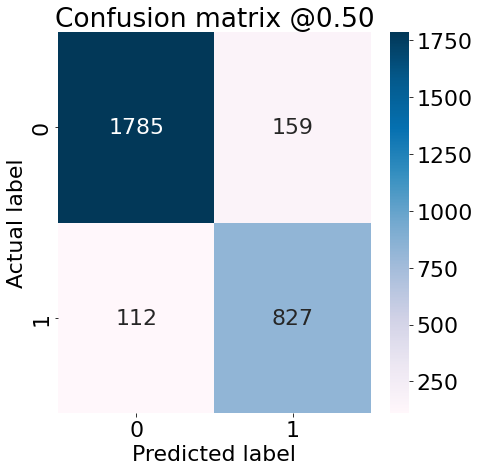

In [158]:
plot_cm(y_test, pred)

In [159]:
def plot_metrics(history):
  metrics = ['loss','accuracy', 'precision', 'recall','auc','prc']
  plt.figure(figsize=(20, 20), tight_layout={'h_pad': 3})
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric],  label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],label='Val')
    plt.xlabel('Epoch', fontdict={'fontsize': 15})
    plt.title(name, fontdict={'fontsize': 21, 'fontweight': 500}, pad=20)
    plt.legend(fontsize=21)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

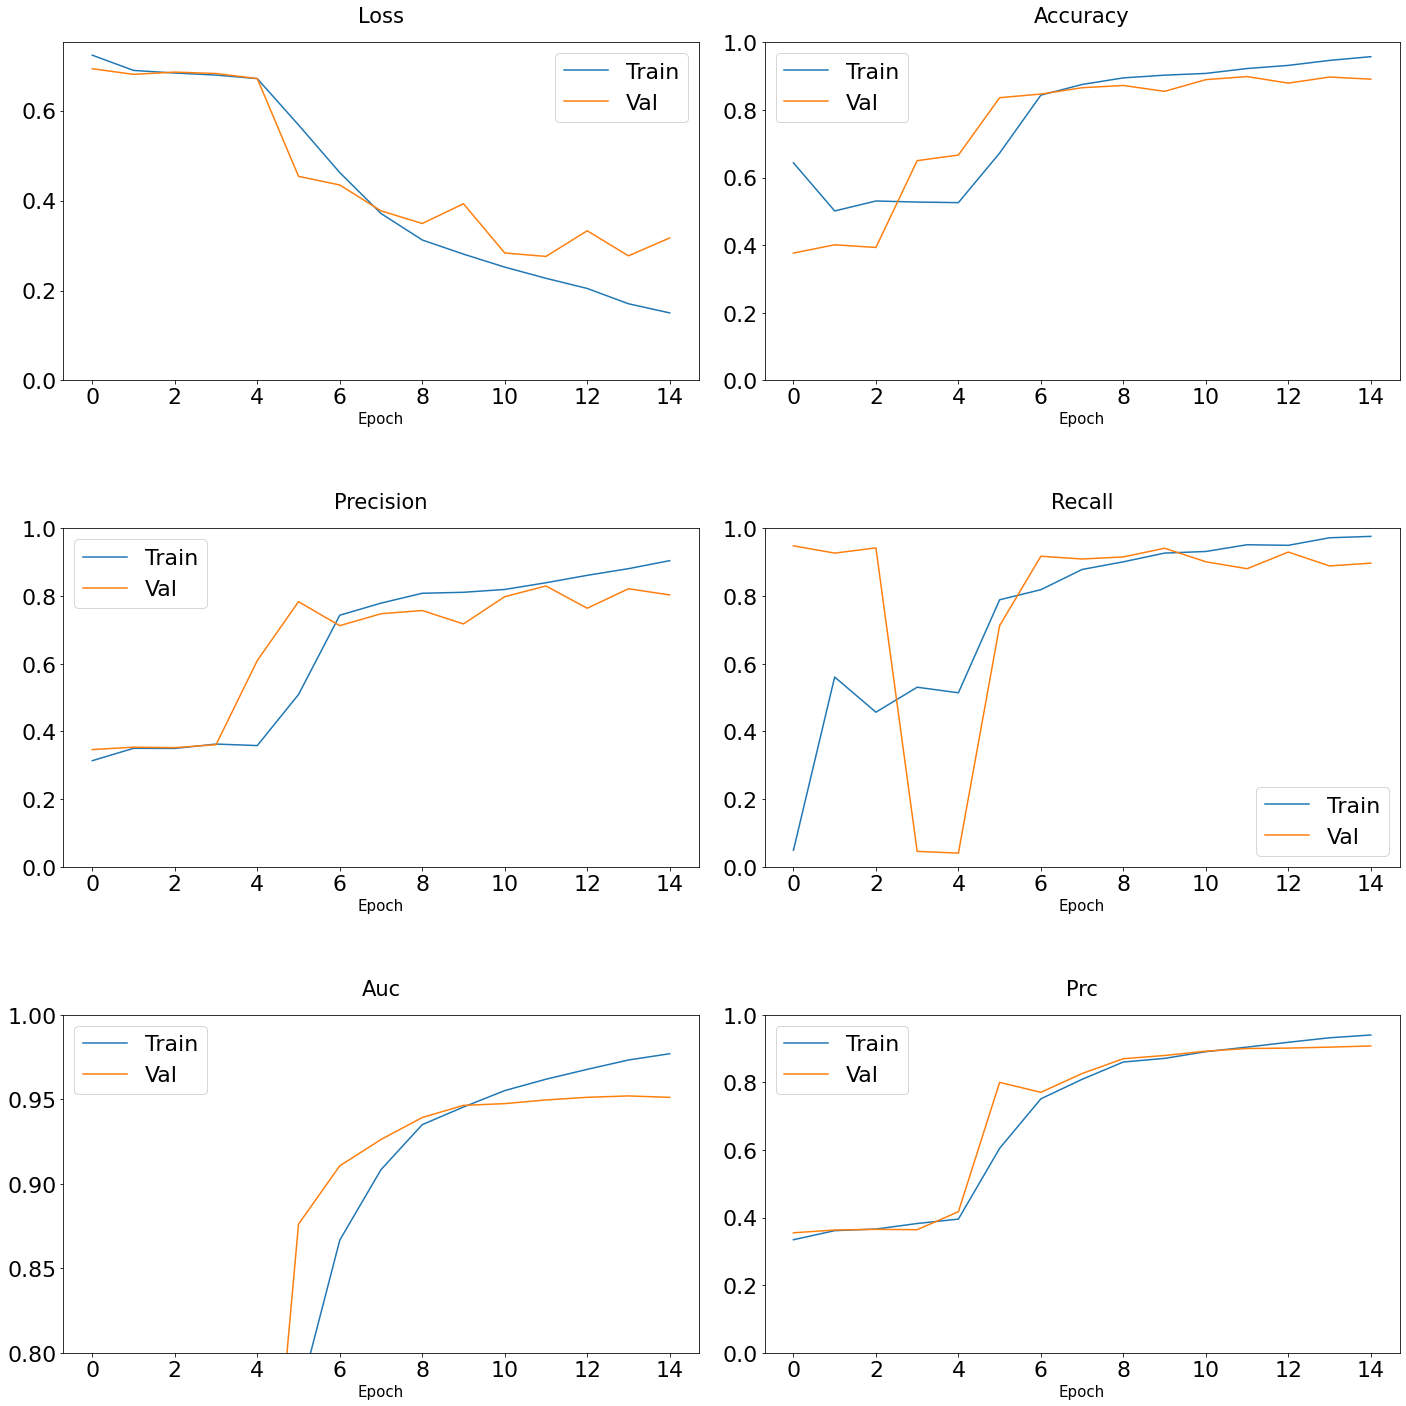

In [160]:
plot_metrics(history)